# Title: NVD, CVE, STIX, etc
### Purpose: Snippets to explore the MITRE datasets
### Author: @mjz


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import argparse
import gzip
import os
import json
# import ijson
import platform
import pathlib
import sys
import logging
import re
import urllib.request
from itertools import chain
from jinja2 import Template

import jupyter_core

# from owlready2 import *
# from stix2 import *
# from stix2 import FileSystemSource as fs
# from stix2 import Filter
# from stix2.utils import get_type_from_id


SEP = os.path.sep

sys.path.append('..')

# MulVal Data Loading
BASE_DIR = '/opt/projects/diss/jupyter_nbs/mine'
# BASE_DIR = '/opt/projects/diss/py-mulval'
DATA_DIR = SEP.join((BASE_DIR, 'data'))
WORKING_DIR = SEP.join((DATA_DIR, 'test_004_nvd'))
DOWNLOAD_DIR = SEP.join((WORKING_DIR, 'downloads'))
PROCESSED_DIR = SEP.join((WORKING_DIR, 'processed'))

# logging.basicConfig(filename=LOG_FILE,level=logging.DEBUG)
# LOG_FILE = SEP.join((WORKING_DIR, '000-nvd_explore.log'))
# logging.basicConfig(
#     level=logging.DEBUG,
#     format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
#     handlers=[
#         logging.FileHandler("{0}/{1}.log".format(WORKING_DIR, '000-nvd_explore')),
#         logging.StreamHandler()
#     ])


CVE_REMOTE_URL = 'http://cve.mitre.org/data/downloads/allitems.csv'
CVE_LOCAL_FILE_NAME_RAW = 'CVE_MITRE_SET.csv'
CVE_LOCAL_FILE_NAME = 'CVE_MITRE_SET.json'
CVE_LOCAL_FILE_RAW = SEP.join((DOWNLOAD_DIR, CVE_LOCAL_FILE_NAME_RAW))
CVE_LOCAL_FILE_PROCESSED = SEP.join((PROCESSED_DIR, CVE_LOCAL_FILE_NAME))

NVD_SCHEMA_REMOTE_URL = 'https://csrc.nist.gov/schema/nvd/feed/1.1/nvd_cve_feed_json_1.1.schema'

NVD_REMOTE_JSON_FEED_LIST = 'https://nvd.nist.gov/vuln/data-feeds#JSON_FEED'
NVD_REMOTE_JSON_FEED_BASE = 'https://nvd.nist.gov/feeds/json/cve/1.1'
NVD_REMOTE_JSON_FILE_PATTERN = r'(nvdcve-1\.1-[0-9]*?\.json\.gz)'  # only pull yearly files
NVD_LOCAL_FILE_NAME = 'nist_nvd.json'
NVD_LOCAL_FILE = SEP.join((PROCESSED_DIR, NVD_LOCAL_FILE_NAME))


# NVD_REMOTE_JSON_FILE_PATTERN = r'(nvdcve-1\.1-[a-zA-Z0-9]*?\.json\.gz)' #  pull modified and recent as well


class mitre_cve(object):
  def __init__(self, *args, **kwargs):
    super(mitre_cve, self)

  def get_cves_from_mitre(self):
    cve_raw = pathlib.Path(CVE_LOCAL_FILE_RAW)

    if not cve_raw.exists():
      logging.debug('downloading cve_raw: %s' % CVE_LOCAL_FILE_RAW)
      urllib.request.urlretrieve(CVE_REMOTE_URL, CVE_LOCAL_FILE_RAW)
    else:
      logging.debug('cve_raw already exists: %s' % CVE_LOCAL_FILE_RAW)

  def convert_cves_to_json(self):
    cve_raw = pathlib.Path(CVE_LOCAL_FILE_NAME_RAW)
    cve_json = pathlib.Path(CVE_LOCAL_FILE_PROCESSED)
    if not cve_json.exists():
      logging.debug('writing cve_json: %s' % CVE_LOCAL_FILE_PROCESSED)
      cve_df = pd.read_csv(cve_raw, sep=',', quotechar='"', header=2,
                           skiprows=range(3, 10), encoding="ISO-8859-1")
      cve_df.to_csv(CVE_LOCAL_FILE_PROCESSED)
    else:
      logging.debug('cve_json already exists: %s' % CVE_LOCAL_FILE_PROCESSED)


class nist_nvd(object):

  def __init__(self, *args, **kwargs):
    super(nist_nvd, self)

    self.nvd_file_list = list()

  def get_nvd_from_nist(self):

    #  download NVD yearly feeds if they don't exist
    feed_list = urllib.request.urlopen(NVD_REMOTE_JSON_FEED_LIST)
    response = feed_list.read()
    for filename in re.findall(NVD_REMOTE_JSON_FILE_PATTERN, str(response)):
      self.nvd_file_list.append(filename)
      outfile_name = SEP.join(((DOWNLOAD_DIR, filename)))
      outfile = pathlib.Path(outfile_name)
      if not outfile.exists():
        logging.debug('downloading nvd_file: %s' % outfile_name)
        urllib.request.urlretrieve(
            '/'.join((NVD_REMOTE_JSON_FEED_BASE, filename)), outfile)
      else:
        logging.debug('found nvd file %s, skipping download...' % outfile)

    logging.debug(self.nvd_file_list)

  def write_nvd_to_json(self, overwrite_if_exists=False):
    outfile = pathlib.Path(NVD_LOCAL_FILE)
    cve_dfs = []
    date_cols = ['publishedDate',
                 'lastModifiedDate']
    bool_cols = ['impact.baseMetricV2.acInsufInfo',
                 'impact.baseMetricV2.obtainAllPrivilege',
                 'impact.baseMetricV2.obtainUserPrivilege',
                 'impact.baseMetricV2.obtainOtherPrivilege',
                 'impact.baseMetricV2.userInteractionRequired']
    category_cols = [
      'cve.data_type',
      'cve.data_format',
      'cve.data_version',
      'cve.CVE_data_meta.ASSIGNER',
      'configurations.CVE_data_version',
      'impact.baseMetricV3.cvssV3.version',
      #        'impact.baseMetricV3.cvssV3.vectorString',
      'impact.baseMetricV3.cvssV3.attackVector',
      'impact.baseMetricV3.cvssV3.attackComplexity',
      'impact.baseMetricV3.cvssV3.privilegesRequired',
      'impact.baseMetricV3.cvssV3.userInteraction',
      'impact.baseMetricV3.cvssV3.scope',
      'impact.baseMetricV3.cvssV3.confidentialityImpact',
      'impact.baseMetricV3.cvssV3.integrityImpact',
      'impact.baseMetricV3.cvssV3.availabilityImpact',
      'impact.baseMetricV3.cvssV3.baseSeverity',
      'impact.baseMetricV2.cvssV2.version',
      #        'impact.baseMetricV2.cvssV2.vectorString',
      'impact.baseMetricV2.cvssV2.accessVector',
      'impact.baseMetricV2.cvssV2.accessComplexity',
      'impact.baseMetricV2.cvssV2.authentication',
      'impact.baseMetricV2.cvssV2.confidentialityImpact',
      'impact.baseMetricV2.cvssV2.integrityImpact',
      'impact.baseMetricV2.cvssV2.availabilityImpact',
      'impact.baseMetricV2.severity',
    ]

    if not outfile.exists() or overwrite_if_exists:
      logging.debug('writing nist_nvd to json: %s...' % NVD_LOCAL_FILE)
      for gzip_file in self.nvd_file_list:
        year_df = pd.read_json(SEP.join((DOWNLOAD_DIR, gzip_file)))
        cve_dfs.append(json_normalize(year_df['CVE_Items']))
      cve_df = pd.concat(cve_dfs, sort=False)
      for col in cve_df.columns:
        print(col)
      cve_df = cve_df.set_index(['cve.CVE_data_meta.ID'])
      cve_df[bool_cols] = cve_df[bool_cols].astype(bool)
      cve_df[category_cols] = cve_df[category_cols].astype('category')
      # 'table="orient" can not yet read timezone ' "data")
      # cve_df[date_cols] = cve_df[date_cols].apply(pd.to_datetime)
      print(cve_df.info())
      cve_df.to_json(NVD_LOCAL_FILE, orient='table')
    else:
      logging.debug('found nvd_nist file at: %s' % NVD_LOCAL_FILE)

  def read_nvd_from_json(self, *args, **kwargs):
    date_cols = ['publishedDate', 'lastModifiedDate']

    # raise NotImplementedError('table="orient" can not yet read timezone ' "data")
    return pd.read_json(NVD_LOCAL_FILE, convert_dates=date_cols, orient='table')
    # return pd.read_json(NVD_LOCAL_FILE, orient='table')


def setup():
  dirs = [WORKING_DIR, DOWNLOAD_DIR, PROCESSED_DIR]

  logging.basicConfig(
      level=logging.DEBUG,
      format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
      handlers=[
        logging.FileHandler(
            "{0}/{1}.log".format(WORKING_DIR, '000-nvd_explore')),
        logging.StreamHandler()
      ])

  for dir in dirs:
    # logging.debug(('creating working directory: %s') % (WORKING_DIR))
    path = pathlib.Path(dir)
    if not path.exists():
      logging.debug('%s doesnt exist, creating...' % path)
      path.mkdir(parents=True, exist_ok=True)
    else:
      logging.debug('%s already exists, skipping...' % path)



In [2]:
print(pd.__version__)
print(np.__version__)

# setup()  # configure logging, create dirs, ...

os.chdir(WORKING_DIR)

# cve = mitre_cve()
# cve.get_cves_from_mitre()
# # cve.write_cves_to_json()
# # cve.convert_cves_to_json(overwrite_if_exists=True)
# cve.convert_cves_to_json()
# # cve_df = cve.read_cves_from_json()
# print(CVE_LOCAL_FILE_PROCESSED)
# # cve_df = pd.read_json(CVE_LOCAL_FILE_PROCESSED,  orient='split')
# print(cve_df.describe())
# print(cve_df.info())
# print(cve_df.head())

nvd = nist_nvd()
nvd.get_nvd_from_nist()
# nvd.write_nvd_to_json(overwrite_if_exists=True)
nvd.write_nvd_to_json()
nvd_df = nvd.read_nvd_from_json()


v2_cols = {'impact.baseMetricV2.cvssV2.version' : 'v2.version',
            'impact.baseMetricV2.cvssV2.vectorString' : 'v2.vectorString',
            'impact.baseMetricV2.cvssV2.accessVector': 'v2.accessVector',
            'impact.baseMetricV2.cvssV2.accessComplexity': 'v2.accessComplexity',
            'impact.baseMetricV2.cvssV2.authentication': 'v2.authentication',
            'impact.baseMetricV2.cvssV2.confidentialityImpact': 'v2.confidentialityImpact',
            'impact.baseMetricV2.cvssV2.integrityImpact': 'v2.integrityImpact',
            'impact.baseMetricV2.cvssV2.availabilityImpact': 'v2.availabilityImpact',
            'impact.baseMetricV2.cvssV2.baseScore': 'v2.baseScore', 
            'impact.baseMetricV2.severity': 'v2.severity',
            'impact.baseMetricV2.exploitabilityScore': 'v2,exploitabilityScore',
            'impact.baseMetricV2.impactScore': 'v2.impactScore', 
            'impact.baseMetricV2.acInsufInfo': 'v2.acInsufInfo',
            'impact.baseMetricV2.obtainAllPrivilege': 'v2.obtainAllPrivilege',
            'impact.baseMetricV2.obtainUserPrivilege': 'v2.obtainUserPrivilege',
            'impact.baseMetricV2.obtainOtherPrivilege': 'v2.obtainOtherPrivilege',
            'impact.baseMetricV2.userInteractionRequired': 'v2.userInteractionRequired'}

v3_cols = {'impact.baseMetricV3.cvssV3.version' : 'v3.version',
           'impact.baseMetricV3.cvssV3.vectorString': 'v3.vectorString',
           'impact.baseMetricV3.cvssV3.attackVector': 'v3.attackVector',
           'impact.baseMetricV3.cvssV3.attackComplexity': 'v3.attackComplexity',
           'impact.baseMetricV3.cvssV3.privilegesRequired': 'v3.privilegesRequired',
           'impact.baseMetricV3.cvssV3.userInteraction': 'v3.userInteraction',
           'impact.baseMetricV3.cvssV3.scope': 'v3.scope',
           'impact.baseMetricV3.cvssV3.confidentialityImpact': 'v3.confidentialityImpact',
           'impact.baseMetricV3.cvssV3.integrityImpact': 'v3.integrityImpact',
           'impact.baseMetricV3.cvssV3.availabilityImpact': 'v3.availabilityImpact',
           'impact.baseMetricV3.cvssV3.baseScore': 'v3.baseScore',
           'impact.baseMetricV3.cvssV3.baseSeverity': 'v3.baseSeverity',
           'impact.baseMetricV3.exploitabilityScore': 'v3.exploitabilityScore',
           'impact.baseMetricV3.impactScore': 'v3.impactScore', }

common_cols = ['publishedDate', 'lastModifiedDate', 'cve.data_type', 'cve.data_format',
       'cve.data_version', 'cve.CVE_data_meta.ASSIGNER',
       'cve.problemtype.problemtype_data', 'cve.references.reference_data',
       'cve.description.description_data', 'configurations.CVE_data_version',
       'configurations.nodes',]

# make easy names
nvd_df = nvd_df.rename(columns={**v2_cols, **v3_cols})

print(nvd_df.describe())
print(nvd_df.info())
print(nvd_df.head())

nvd_df.describe()

0.25.3
1.17.4
       v3.baseScore  v3.exploitabilityScore  v3.impactScore   v2.baseScore  \
count  58432.000000             58432.00000    58432.000000  131968.000000   
mean       7.280519                 2.74185        4.400089       6.049358   
std        1.637548                 0.92734        1.498463       2.008785   
min        1.800000                 0.10000        1.400000       0.000000   
25%        6.100000                 1.80000        3.600000       4.300000   
50%        7.500000                 2.80000        3.600000       5.800000   
75%        8.800000                 3.90000        5.900000       7.500000   
max       10.000000                 3.90000        6.000000      10.000000   

       v2,exploitabilityScore  v2.impactScore  
count           131968.000000   131968.000000  
mean                 8.206656        5.594703  
std                  2.141110        2.641358  
min                  1.200000        0.000000  
25%                  8.000000        2.9000

,v3.baseScore,v3.exploitabilityScore,v3.impactScore,v2.baseScore,"v2,exploitabilityScore",v2.impactScore
count,58432.000000,58432.00000,58432.000000,131968.000000,131968.000000,131968.000000
mean,7.280519,2.74185,4.400089,6.049358,8.206656,5.594703
std,1.637548,0.92734,1.498463,2.008785,2.141110,2.641358
min,1.800000,0.10000,1.400000,0.000000,1.200000,0.000000
25%,6.100000,1.80000,3.600000,4.300000,8.000000,2.900000
50%,7.500000,2.80000,3.600000,5.800000,8.600000,6.400000
75%,8.800000,3.90000,5.900000,7.500000,10.000000,6.400000
max,10.000000,3.90000,6.000000,10.000000,10.000000,10.000000


# CVE

In [3]:
# cve_df.set_index('Name')
cve_df.columns

NameError: name 'cve_df' is not defined

In [ ]:
cve_df.describe()

# CVSS / NVD

https://avleonov.com/2017/10/03/downloading-and-analyzing-nvd-cve-feed/



In [4]:
print(nvd_df.shape)
print('=========')
print(nvd_df.describe())

(140230, 42)
       v3.baseScore  v3.exploitabilityScore  v3.impactScore   v2.baseScore  \
count  58432.000000             58432.00000    58432.000000  131968.000000   
mean       7.280519                 2.74185        4.400089       6.049358   
std        1.637548                 0.92734        1.498463       2.008785   
min        1.800000                 0.10000        1.400000       0.000000   
25%        6.100000                 1.80000        3.600000       4.300000   
50%        7.500000                 2.80000        3.600000       5.800000   
75%        8.800000                 3.90000        5.900000       7.500000   
max       10.000000                 3.90000        6.000000      10.000000   

       v2,exploitabilityScore  v2.impactScore  
count           131968.000000   131968.000000  
mean                 8.206656        5.594703  
std                  2.141110        2.641358  
min                  1.200000        0.000000  
25%                  8.000000        2.90000

In [5]:
print(nvd_df.dtypes)
print('===========')
print(nvd_df.info())

publishedDate                       datetime64[ns, UTC]
lastModifiedDate                    datetime64[ns, UTC]
cve.data_type                                  category
cve.data_format                                category
cve.data_version                               category
cve.CVE_data_meta.ASSIGNER                     category
cve.problemtype.problemtype_data                 object
cve.references.reference_data                    object
cve.description.description_data                 object
configurations.CVE_data_version                category
configurations.nodes                             object
v3.version                                     category
v3.vectorString                                  object
v3.attackVector                                category
v3.attackComplexity                            category
v3.privilegesRequired                          category
v3.userInteraction                             category
v3.scope                                       c

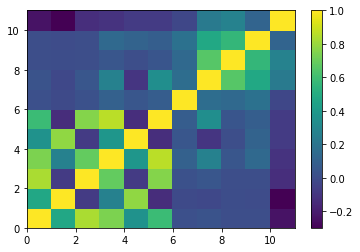

In [6]:
# nvd_df.sort_values(by=["impact.baseMetricV2.cvssV2.baseScore","impact.baseMetricV2.exploitabilityScore",])


# vars_to_use = ['impact.baseMetricV2.cvssV2.baseScore', 
#                'impact.baseMetricV2.severity', 
#                'impact.baseMetricV2.obtainAllPrivilege', 
#                'impact.baseMetricV2.userInteractionRequired', 
#               'impact.baseMetricV3.cvssV3.baseScore',
#               'impact.baseMetricV2.obtainUserPrivilege'] # pick vars

# vars_to_use = ['v2.baseScore', 
#                'v2.severity', 
#                'v2.obtainAllPrivilege', 
#                'v2.userInteractionRequired', 
#               'v3.baseScore',
#               'v2.obtainUserPrivilege'] # pick vars

vars_to_use = ['publishedDate', 'lastModifiedDate', 'cve.data_type', 'cve.data_format',
       'cve.data_version', 'cve.CVE_data_meta.ASSIGNER',
       'cve.problemtype.problemtype_data', 'cve.references.reference_data',
       'cve.description.description_data', 'configurations.CVE_data_version',
       'configurations.nodes', 'v3.version', 'v3.vectorString',
       'v3.attackVector', 'v3.attackComplexity', 'v3.privilegesRequired',
       'v3.userInteraction', 'v3.scope', 'v3.confidentialityImpact',
       'v3.integrityImpact', 'v3.availabilityImpact', 'v3.baseScore',
       'v3.baseSeverity', 'v3.exploitabilityScore', 'v3.impactScore',
       'v2.version', 'v2.vectorString', 'v2.accessVector',
       'v2.accessComplexity', 'v2.authentication', 'v2.confidentialityImpact',
       'v2.integrityImpact', 'v2.availabilityImpact', 'v2.baseScore',
       'v2.severity', 'v2,exploitabilityScore', 'v2.impactScore',
       'v2.acInsufInfo', 'v2.obtainAllPrivilege', 'v2.obtainUserPrivilege',
       'v2.obtainOtherPrivilege', 'v2.userInteractionRequired']

plt.pcolor(nvd_df[vars_to_use].corr()) # do the feature correlation plot

# fill in the indices
# plt.yticks(np.arange(len(vars_to_use)), vars_to_use)
# plt.xticks(np.arange(len(vars_to_use)), vars_to_use)
plt.colorbar()
plt.show()

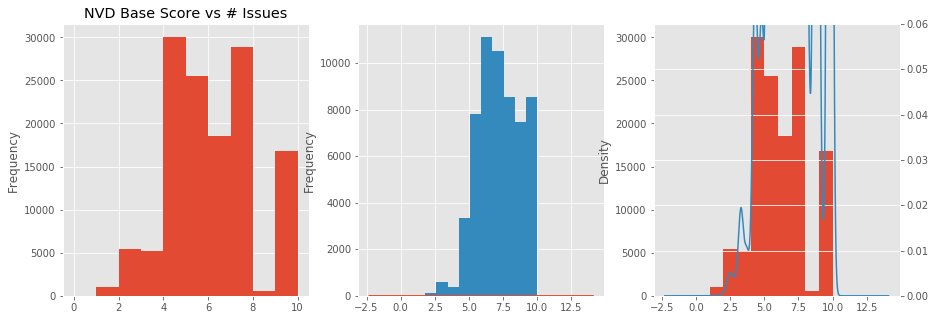

In [8]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.gca().set_title('NVD Base Score vs # Issues')
nvd_df['v2.baseScore'].plot.hist(bins=10)

plt.subplot(1,3,2)
nvd_df['v3.baseScore'].plot.kde(bw_method=0.2)
nvd_df['v3.baseScore'].plot.hist(bins=10)

plt.subplot(1,3,3)
nvd_df['v2.baseScore'].plot.hist(bins=10)
nvd_df['v3.baseScore'].plot.kde(bw_method=0.1, secondary_y=True)
plt.ylim([0, 0.06])

plt.show()

In [ ]:
nvd_df.columns

In [ ]:
nvd_df['v3.privilegesRequired'].describe()

In [ ]:
v2_cols = {'impact.baseMetricV2.cvssV2.version' : 'v2.version',
            'impact.baseMetricV2.cvssV2.vectorString' : 'v2.vectorString',
            'impact.baseMetricV2.cvssV2.accessVector': 'v2.accessVector',
            'impact.baseMetricV2.cvssV2.accessComplexity': 'v2.accessComplexity',
            'impact.baseMetricV2.cvssV2.authentication': 'v2.authentication',
            'impact.baseMetricV2.cvssV2.confidentialityImpact': 'v2.confidentialityImpact',
            'impact.baseMetricV2.cvssV2.integrityImpact': 'v2.integrityImpact',
            'impact.baseMetricV2.cvssV2.availabilityImpact': 'v2.availabilityImpact',
            'impact.baseMetricV2.cvssV2.baseScore': 'v2.baseScore', 
            'impact.baseMetricV2.severity': 'v2.severity',
            'impact.baseMetricV2.exploitabilityScore': 'v2,exploitabilityScore',
            'impact.baseMetricV2.impactScore': 'v2.impactScore', 
            'impact.baseMetricV2.acInsufInfo': 'v2.acInsufInfo',
            'impact.baseMetricV2.obtainAllPrivilege': 'v2.obtainAllPrivilege',
            'impact.baseMetricV2.obtainUserPrivilege': 'v2.obtainUserPrivilege',
            'impact.baseMetricV2.obtainOtherPrivilege': 'v2.obtainOtherPrivilege',
            'impact.baseMetricV2.userInteractionRequired': 'v2.userInteractionRequired`'}

v3_cols = {'impact.baseMetricV3.cvssV3.version' : 'v3.version',
           'impact.baseMetricV3.cvssV3.vectorString': 'v3.vectorString',
           'impact.baseMetricV3.cvssV3.attackVector': 'v3.attackVector',
           'impact.baseMetricV3.cvssV3.attackComplexity': 'v3.attackComplexity',
           'impact.baseMetricV3.cvssV3.privilegesRequired': 'v3.privilegesRequired',
           'impact.baseMetricV3.cvssV3.userInteraction': 'v3.userInteraction',
           'impact.baseMetricV3.cvssV3.scope': 'v3.scope',
           'impact.baseMetricV3.cvssV3.confidentialityImpact': 'v3.confidentialityImpact',
           'impact.baseMetricV3.cvssV3.integrityImpact': 'v3.integrityImpact',
           'impact.baseMetricV3.cvssV3.availabilityImpact': 'v3.availabilityImpact',
           'impact.baseMetricV3.cvssV3.baseScore': 'v3.baseScore',
           'impact.baseMetricV3.cvssV3.baseSeverity': 'v3.baseSeverity',
           'impact.baseMetricV3.exploitabilityScore': 'v3.exploitabilityScore',
           'impact.baseMetricV3.impactScore': 'v3.impactScore', }

common_cols = ['publishedDate', 'lastModifiedDate', 'cve.data_type', 'cve.data_format',
       'cve.data_version', 'cve.CVE_data_meta.ASSIGNER',
       'cve.problemtype.problemtype_data', 'cve.references.reference_data',
       'cve.description.description_data', 'configurations.CVE_data_version',
       'configurations.nodes',]

nvd_df = nvd_df.rename(columns={**v2_cols, **v3_cols})
nvd_df.describe()


In [ ]:
nvd_df.info()

In [ ]:
# df_grouped = nvd_df.groupby(by=[
#        'v3.attackVector', 'v3.attackComplexity', 'v3.privilegesRequired',
#        'v3.userInteraction', 'v3.scope', 'v3.confidentialityImpact',
#        'v3.integrityImpact', 'v3.availabilityImpact',
#        'v2.accessComplexity', 'v2.authentication', 'v2.confidentialityImpact',
#        'v2.integrityImpact', 'v2.availabilityImpact',
#        'v2.severity',
#        'v2.acInsufInfo', 'v2.obtainAllPrivilege', 'v2.obtainUserPrivilege',
#        'v2.obtainOtherPrivilege', 'v2.userInteractionRequired'])

df_grouped = nvd_df.groupby(by=[
       'v2.accessVector', 'v2.obtainAllPrivilege'])
# df_grouped = nvd_df.groupby(by=[
#        'v3.attackVector', 'v2.obtainAllPrivilege'])
# print (df_grouped.describe())

In [ ]:
df_grouped.describe()

In [ ]:
print(nvd_df['v3.attackVector'].cat.categories)
print(nvd_df['v2.accessVector'].cat.categories)

In [ ]:
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

print('Seaborn:', sns. __version__)


In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(nvd_df.corr(), cmap=cmap, annot=True)

f.tight_layout()

In [ ]:
# nvd_df.columns.to_series().groupby(nvd_df.dtypes).groups

In [ ]:
# sns.pairplot(nvd_df, hue="v3.attackVector", size=2,
#             plot_kws=dict(s=20, alpha=0.15, linewidth=0))
# df = 
sns.pairplot(nvd_df.select_dtypes(include=['float']), )

plt.show()

In [ ]:
nvd_df.columns

In [ ]:
sns.set(style="ticks", color_codes=True)

# sns.pairplot(nvd_df.select_dtypes(include=['float']),)

sns.catplot(x='v3.attackVector', y='v2,exploitabilityScore', data=nvd_df)

In [ ]:

float_cols = nvd_df.select_dtypes(include=['float']).columns
cat_cols = nvd_df.select_dtypes(include=['category']).columns

# sns.pairplot(nvd_df.select_dtypes(include=['float']), )
sns.pairplot( data=nvd_df, x_vars=float_cols, y_vars=cat_cols,hue='v2.obtainAllPrivilege')
plt.show()

In [ ]:

float_cols = nvd_df.select_dtypes(include=['float']).columns
bool_cols = nvd_df.select_dtypes(include=['bool']).columns

# sns.pairplot(nvd_df.select_dtypes(include=['float']), )
sns.pairplot( data=nvd_df, x_vars=float_cols, y_vars=bool_cols,hue='v3.attackVector')
plt.show()

In [ ]:
nvd_df.columns

In [ ]:
# fig, ax = plt.subplots(figsize=(15,7))
# nvd_df.groupby(['v2.accessVector', 'v3.attackVector','publishedDate']).count().ungroup().plot(ax=ax)

nvdAVbyYr = nvd_df.groupby([nvd_df['publishedDate'].dt.year, 'v2.accessVector'])['v2.accessVector'].count()
# nvdAVbyYr.plot(ax=ax)
nvdAVbyYr
# nvdAVbyYr.unstack()

In [ ]:
# df_access_vector_group = nvdAVbyYr.groupby(nvdAVbyYr['v2.accessVector'])
# df_access_vector_group

nvd_plot = nvdAVbyYr.unstack().plot(kind='bar',stacked=True,title="Total NVD Vulerabilities by Access Vector",figsize=(12, 9))
nvd_plot.set_xlabel("Year")
nvd_plot.set_ylabel("Vuln Count")